# Build per-arm Bandit model with TF-Agents and execute locally with Vertex AI

## background

**Arm features**
* In some bandits use cases, each arm has its own features. For example, in movie recommendation problems, the user features play the role of the context and the movies play the role of the arms (aka actions) 
* Each movie has its own features, such as `text description`, `metadata`, `trailer content` features and so on

These problems are often referred to as `arm features problems`

In [1]:
! python3 -c "import google.cloud.aiplatform; print('aiplatform SDK version: {}'.format(google.cloud.aiplatform.__version__))"

aiplatform SDK version: 1.33.1


## Load env config

* use the prefix from `00-env-setup`

In [2]:
# PREFIX = 'mabv1'
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


**run the next cell to populate env vars**

In [3]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_ID      = "hybrid_vertex.movielens_ds_rec_bandits_v2"
BIGQUERY_TABLE_ID        = "hybrid_vertex.movielens_ds_rec_bandits_v2.training_dataset"

REPO

In [4]:
# ! gsutil ls $BUCKET_URI

## imports

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
import functools
import json
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint

import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
from tf_agents.agents import TFAgent
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.bandits.environments import (environment_utilities,
                                            movielens_py_environment,
                                            movielens_per_arm_py_environment)
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import TFEnvironment, tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.metrics.tf_metric import TFStepMetric
from tf_agents.policies import policy_saver

# GPU
from numba import cuda 
import gc

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

In [7]:
import sys
sys.path.append("..")

# my project
from src.per_arm_rl import data_utils
from src.per_arm_rl import data_config
from src.per_arm_rl import trainer_baseline

### detect GPUs & reset devices

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

### Initialize Google Cloud SDK Clients

In [11]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# Data prep

### copy sample data to $DATA_PATH

### Load data config

In [12]:
# test variables are set
print(f"USER_AGE_LOOKUP: {data_config.USER_AGE_LOOKUP}")
print(f"USER_AGE_DIM: {data_config.USER_AGE_DIM}")

print(f"USER_OCC_LOOKUP: {data_config.USER_OCC_LOOKUP}")
print(f"USER_OCC_DIM: {data_config.USER_OCC_DIM}")

print(f"MOVIE_GEN_LOOKUP: {data_config.MOVIE_GEN_LOOKUP}")
print(f"MOVIE_GEN_DIM: {data_config.MOVIE_GEN_DIM}")

print(f"MOVIELENS_NUM_MOVIES: {data_config.MOVIELENS_NUM_MOVIES}")
print(f"MOVIELENS_NUM_USERS: {data_config.MOVIELENS_NUM_USERS}")

USER_AGE_LOOKUP: {1.0: 0, 35.0: 1, 45.0: 2, 18.0: 3, 50.0: 4, 56.0: 5, 25.0: 6}
USER_AGE_DIM: 7
USER_OCC_LOOKUP: {b'salesman': 0, b'programmer': 1, b'writer': 2, b'librarian': 3, b'marketing': 4, b'homemaker': 5, b'scientist': 6, b'entertainment': 7, b'engineer': 8, b'executive': 9, b'student': 10, b'technician': 11, b'none': 12, b'artist': 13, b'doctor': 14, b'lawyer': 15, b'retired': 16, b'administrator': 17, b'other': 18, b'educator': 19, b'healthcare': 20}
USER_OCC_DIM: 21
MOVIE_GEN_LOOKUP: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18}
MOVIE_GEN_DIM: 19
MOVIELENS_NUM_MOVIES: 1682
MOVIELENS_NUM_USERS: 943


In [13]:
# type(data_config.USER_OCC_LOOKUP)

### Read TF Records

In [14]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [15]:
SPLIT = "train" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/', delimiter="/"): # {SPLIT}
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files

['gs://rec-bandits-v2-hybrid-vertex-bucket/data/ml-ratings-100k-full.tfrecord']

In [16]:
train_dataset = tf.data.TFRecordDataset(train_files)

train_dataset = train_dataset.map(data_utils.parse_tfrecord)

train_dataset

<_MapDataset element_spec={'bucketized_user_age': TensorSpec(shape=(), dtype=tf.float32, name=None), 'movie_genres': TensorSpec(shape=(1,), dtype=tf.int64, name=None), 'movie_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'timestamp': TensorSpec(shape=(), dtype=tf.int64, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_occupation_text': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(), dtype=tf.float32, name=None)}>

In [17]:
for x in train_dataset.batch(1).take(2):
    pprint(x)

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([45.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[7]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'357'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([879024327])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'138'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'doctor'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}
{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([25.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[4]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'709'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([875654590])>,
 'user_id': <tf.Tensor: shape=(1

# Define RL modules

In [19]:
# !pwd

# Train RL modules

### set hyperparameters

In [20]:
# Set hyperparameters.
BATCH_SIZE       = 128      # Training and prediction batch size.
TRAINING_LOOPS   = 100     # Number of training iterations.
STEPS_PER_LOOP   = 2      # Number of driver steps per training iteration.

# Set MovieLens simulation environment parameters.
RANK_K           = 20     # Rank for matrix factorization in the MovieLens environment; also the observation dimension.
NUM_ACTIONS      = 10     # Number of actions (movie items) to choose from.
PER_ARM          = True   # Use the non-per-arm version of the MovieLens environment.

# Set agent parameters.
TIKHONOV_WEIGHT  = 0.001   # LinUCB Tikhonov regularization weight.
AGENT_ALPHA      = 10.0    # LinUCB exploration parameter that multiplies the confidence intervals.

print(f"BATCH_SIZE       : {BATCH_SIZE}")
print(f"TRAINING_LOOPS   : {TRAINING_LOOPS}")
print(f"STEPS_PER_LOOP   : {STEPS_PER_LOOP}")
print(f"RANK_K           : {RANK_K}")
print(f"NUM_ACTIONS      : {NUM_ACTIONS}")
print(f"PER_ARM          : {PER_ARM}")
print(f"TIKHONOV_WEIGHT  : {TIKHONOV_WEIGHT}")
print(f"AGENT_ALPHA      : {AGENT_ALPHA}")

BATCH_SIZE       : 128
TRAINING_LOOPS   : 100
STEPS_PER_LOOP   : 2
RANK_K           : 20
NUM_ACTIONS      : 10
PER_ARM          : True
TIKHONOV_WEIGHT  : 0.001
AGENT_ALPHA      : 10.0


### Define RL environment

One can define a bandit environment by subclassing `BanditTFEnvironment`, or, similarly to RL environments, one can define a `BanditPyEnvironment` and wrap it with `TFPyEnvironment`

> See `src.per_arm_rl.my_per_arm_py_env.py` for an example custom environment which implements a per-arm version of the MovieLens environment

In [21]:
from src.per_arm_rl import my_per_arm_py_env as my_per_arm_py_env

In [22]:
data_config.MOVIELENS_NUM_USERS

943

In [23]:
env = my_per_arm_py_env.MyMovieLensPerArmPyEnvironment(
    project_number = PROJECT_NUM
    , data_path = DATA_PATH
    , bucket_name = BUCKET_NAME
    , data_gcs_prefix = f"{DATA_GCS_PREFIX}"
    , user_age_lookup_dict = data_config.USER_AGE_LOOKUP
    , user_occ_lookup_dict = data_config.USER_OCC_LOOKUP
    , movie_gen_lookup_dict = data_config.MOVIE_GEN_LOOKUP
    , num_users = data_config.MOVIELENS_NUM_USERS
    , num_movies = data_config.MOVIELENS_NUM_MOVIES
    , rank_k = RANK_K
    , batch_size = BATCH_SIZE
    , num_actions = NUM_ACTIONS
)

environment = tf_py_environment.TFPyEnvironment(env)

In [24]:
env.movie_gen_lookup_dict

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18}

In [25]:
env.dataset

<_MapDataset element_spec={'bucketized_user_age': TensorSpec(shape=(), dtype=tf.float32, name=None), 'movie_genres': TensorSpec(shape=(1,), dtype=tf.int64, name=None), 'movie_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'timestamp': TensorSpec(shape=(), dtype=tf.int64, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_occupation_text': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(), dtype=tf.float32, name=None)}>

In [26]:
env._user_occ_int

array([14.0001,  7.0001, 10.0001, ..., 10.0001,  2.0001, 10.0001])

In [27]:
environment.observation_spec()

{'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(10, 21), dtype=tf.float32, name=None)}

In [28]:
environment.time_step_spec()

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(10, 21), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [29]:
environment.action_spec()

BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(9, dtype=int32))

### Define RL agent/algorithm

In [30]:
agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec = environment.time_step_spec()
    , action_spec = environment.action_spec()
    , tikhonov_weight = TIKHONOV_WEIGHT
    , alpha = AGENT_ALPHA
    , dtype = tf.float32
    , accepts_per_arm_features = PER_ARM
    , summarize_grads_and_vars = True
    , enable_summaries = True,
)

print("TimeStep Spec (for each batch):\n", agent.time_step_spec, "\n")
print("Action Spec (for each batch)  :\n", agent.action_spec, "\n")
print("Reward Spec (for each batch)  :\n", environment.reward_spec(), "\n")

TimeStep Spec (for each batch):
 TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': DictWrapper({'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(10, 21), dtype=tf.float32, name=None)}),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}) 

Action Spec (for each batch)  :
 BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(9, dtype=int32)) 

Reward Spec (for each batch)  :
 TensorSpec(shape=(), dtype=tf.float32, name='reward') 



#### The flow of training data

First, let us have a look at the data specification in the agent. The `training_data_spec` attribute of the agent specifies what elements and structure the training data should have.

In [31]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(9, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=(), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(21,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


If we have a closer look to the `observation` part of the spec, we see that it does not contain per-arm features!

In [32]:
print('observation spec in training: ', agent.training_data_spec.observation)

observation spec in training:  {'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None)}


What happened to the per-arm features? To answer this question, first we note that when the LinUCB agent trains, it does not need the per-arm features of all arms, it only needs those of the **chosen arm**. Hence, it makes sense to drop the tensor of shape `[BATCH_SIZE, NUM_ACTIONS, PER_ARM_DIM]`, as it is very wasteful, especially if the number of actions is large.

But still, the per-arm features of the chosen arm must be somewhere! To this end, we make sure that the LinUCB policy stores the features of the chosen arm within the `policy_info` field of the training data:

In [33]:
print('chosen arm features: ', agent.training_data_spec.policy_info.chosen_arm_features)

chosen arm features:  TensorSpec(shape=(21,), dtype=tf.float32, name=None)


### Define RL metric

Bandits' most important metric is **regret**, calculated as the difference between the reward collected by the agent and the expected reward of an oracle policy that has access to the reward functions of the environment. The [RegretMetric](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/metrics/tf_metrics.py) thus needs a `baseline_reward_fn` function that calculates the best achievable expected reward given an observation. For our example, we need to take the maximum of the no-noise equivalents of the reward functions that we already defined for the environment.

In [34]:
optimal_reward_fn = functools.partial(
    environment_utilities.compute_optimal_reward_with_movielens_environment
    , environment=environment
)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)

suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
  optimal_action_fn
)

metrics = [regret_metric, suboptimal_arms_metric]

In [35]:
metrics

In [36]:
# optimal_reward_fn

## Train (locally)

A **policy** in a bandit problem works the same way as in an RL problem: it provides an action (or a distribution of actions), given an observation as input.
* For more details, see the [TF-Agents Policy tutorial](https://github.com/tensorflow/agents/blob/master/docs/tutorials/3_policies_tutorial.ipynb).
* As with environments, there are two ways to construct a policy: One can create a `PyPolicy` and wrap it with `TFPyPolicy`, or directly create a `TFPolicy`

**Replay buffers**
* Reinforcement learning algorithms use `replay buffers` to store trajectories of experience when executing a policy in an environment. * During training, replay buffers are queried for a subset of the trajectories (either a sequential subset or a sample) to "replay" the agent's experience.

### Define the training logic (on-policy training)

> The following function is the same as [trainer.train](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/examples/v2/trainer.py#L130), but it keeps track of intermediate metric values and saves different artifacts to different locations. You can also directly invoke [trainer.train](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/examples/v2/trainer.py#L130) which also trains the policy.

### set Vertex Exeperiment

In [37]:
EXPERIMENT_NAME   = f'baseline-perarm-local-v1'

invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

LOG_DIR           = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/tb-logs"
ROOT_DIR          = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : baseline-perarm-local-v1
RUN_NAME          : run-20231018-135448
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/baseline-perarm-local-v1/run-20231018-135448/tb-logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/baseline-perarm-local-v1/run-20231018-135448/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/baseline-perarm-local-v1/run-20231018-135448/artifacts


### train RL agent

> TODO: out-of-bounds index error

In [39]:
#start the timer and training
start_time = time.time()

# tf.profiler.experimental.start(LOG_DIR)

metric_results = trainer_baseline.train(
    root_dir=LOG_DIR,
    agent=agent,
    environment=environment,
    training_loops=TRAINING_LOOPS,
    steps_per_loop=STEPS_PER_LOOP,
    additional_metrics=metrics,
    save_policy=True
)
# tf.profiler.experimental.stop()

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)

step = 0: train loss = 0.6000000238418579
step = 25: train loss = 0.9599999785423279
step = 50: train loss = 1.0
step = 75: train loss = 0.9100000262260437


In [40]:
metric_results

### log Vertex Experiment run

In [37]:
# aiplatform.start_run(
#     RUN_NAME
#     , tensorboard=TB_RESOURCE_NAME
#     , resume=False
# )

# aiplatform.log_params(
#     {
#         "runtime": runtime_mins,
#         "batch_size": BATCH_SIZE, 
#         "training_loops": TRAINING_LOOPS,
#         "steps_pre_loop": STEPS_PER_LOOP,
#         "rank_k": RANK_K,
#         "num_actions": NUM_ACTIONS,
#         "per_arm": PER_ARM,
#         "tikhonov_weight": TIKHONOV_WEIGHT,
#         "agent_alpha": AGENT_ALPHA,
#     }
# )

# # gather the metrics for the last epoch to be saved in metrics
# aiplatform.log_metrics(
#     {
#         "AverageReturnMetric" : float(metric_results["AverageReturnMetric"][-1])
#         , "FinalRegretMetric" : float(metric_results["RegretMetric"][-1])
#     }
# )

# aiplatform.end_run()

## Evaluate RL metrics

In [39]:
# def plot(metric_results, metric_name):
#     plt.plot(metric_results[metric_name])
#     plt.ylabel(metric_name)
#     plt.xlabel("Step")
#     plt.title("{} versus Step".format(metric_name))

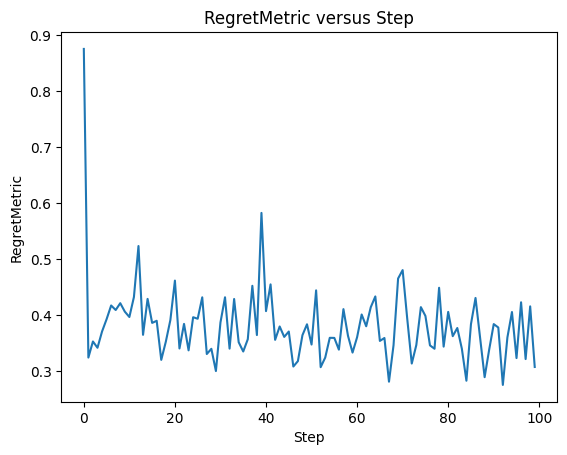

In [40]:
# plot(metric_results, "RegretMetric")

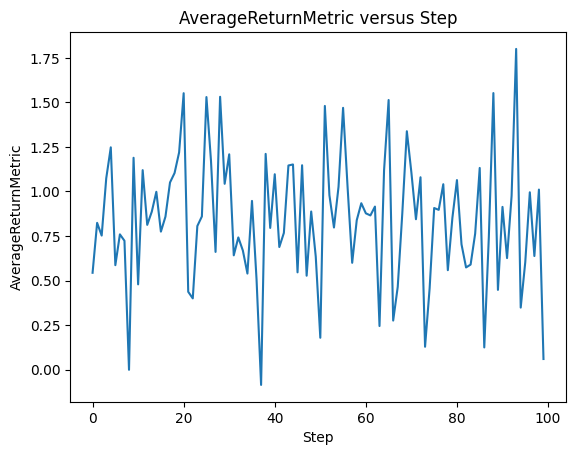

In [41]:
# plot(metric_results, "AverageReturnMetric")

### Profiler

In [41]:
%load_ext tensorboard
# %reload_ext tensorboard

In [42]:
%tensorboard --logdir=$LOG_DIR

### load trained policy

In [43]:
!gsutil ls $LOG_DIR

gs://mabv1-hybrid-vertex-bucket/baseline-perarm-local-v1/run-20231004-130954/tb-logs/
gs://mabv1-hybrid-vertex-bucket/baseline-perarm-local-v1/run-20231004-130954/tb-logs/checkpoint
gs://mabv1-hybrid-vertex-bucket/baseline-perarm-local-v1/run-20231004-130954/tb-logs/ckpt-100.data-00000-of-00001
gs://mabv1-hybrid-vertex-bucket/baseline-perarm-local-v1/run-20231004-130954/tb-logs/ckpt-100.index
gs://mabv1-hybrid-vertex-bucket/baseline-perarm-local-v1/run-20231004-130954/tb-logs/ckpt-96.data-00000-of-00001
gs://mabv1-hybrid-vertex-bucket/baseline-perarm-local-v1/run-20231004-130954/tb-logs/ckpt-96.index
gs://mabv1-hybrid-vertex-bucket/baseline-perarm-local-v1/run-20231004-130954/tb-logs/ckpt-97.data-00000-of-00001
gs://mabv1-hybrid-vertex-bucket/baseline-perarm-local-v1/run-20231004-130954/tb-logs/ckpt-97.index
gs://mabv1-hybrid-vertex-bucket/baseline-perarm-local-v1/run-20231004-130954/tb-logs/ckpt-98.data-00000-of-00001
gs://mabv1-hybrid-vertex-bucket/baseline-perarm-local-v1/run-202310

In [48]:
# trained_policy = tf.saved_model.load(LOG_DIR)
# trained_policy

# Make predictions

In [205]:
environment._u_hat

sampled_user_ages = np.ones(BATCH_SIZE)
sampled_user_occ = np.ones(BATCH_SIZE)

SAMPLED_USER_INDICES = np.random.randint(NUM_USERS, size=BATCH_SIZE)
SAMPLED_USER_INDICES

combined_user_features = np.concatenate(
    (
        environment._u_hat[SAMPLED_USER_INDICES]
        , sampled_user_ages.reshape(-1,1)
        , sampled_user_occ.reshape(-1,1)
    )
    , axis=1
)

In [206]:
SAMPLED_USER_INDICES

array([75, 30, 34,  2, 33, 96, 78, 85])

In [210]:
sampled_u_hats_pred = environment._u_hat[SAMPLED_USER_INDICES]
# sampled_u_hats_pred

In [204]:
environment._u_hat

array([[-0.0658043 ,  0.00597506, -0.00613256, ...,  0.01743993,
        -0.03573092,  0.03894605],
       [-0.01402104, -0.04662602,  0.05257856, ...,  0.01171281,
         0.01670101, -0.01658576],
       [-0.00565798, -0.02561845,  0.02336183, ..., -0.01843041,
        -0.02539826, -0.0020144 ],
       ...,
       [-0.00744452, -0.02502129,  0.00616532, ..., -0.03812664,
         0.03884653,  0.01103627],
       [-0.02403119,  0.00809611,  0.02288736, ..., -0.0200555 ,
         0.00571077, -0.00570774],
       [-0.04224209, -0.01092715, -0.05854604, ...,  0.02310407,
        -0.03948996, -0.0340745 ]], dtype=float32)

In [212]:
# user_ids_pred = np.array([1,2,3,4,5,6,7])
user_age_pred = np.array([1,1,1,1,1,1,1,1])
user_occ_pred = np.array([1,1,1,1,1,1,1,1])

combined_user_features = np.concatenate(
    (
        # user_ids_pred
        sampled_u_hats_pred
        , user_age_pred.reshape(-1,1)
        , user_occ_pred.reshape(-1,1)
    )
    , axis=1
)

combined_user_features.shape

(8, 22)

# Notes
* debugging tips and things to consider

### Observation spec

In [189]:
# observation_list = [list(np.ones(RANK_K + 2)) for _ in range(BATCH_SIZE)]
# observation_list

# batched_observations = {
#     GLOBAL_KEY:
#         tf.convert_to_tensor(combined_user_features, dtype=tf.float32),
#     PER_ARM_KEY:
#         tf.convert_to_tensor(current_movies, dtype=tf.float32),
# }

# batched_observations

observation_dict = {
    GLOBAL_KEY:
        np.zeros([BATCH_SIZE, RANK_K + 2], dtype=np.int32), #making space like above for dimensions
    PER_ARM_KEY:
        np.zeros([BATCH_SIZE, NUM_ACTIONS, RANK_K + 1], dtype=np.int32),
}

print(f"observation_dict  : {observation_dict}")

observation_dict  : {'global': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32), 'per_arm': array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 

In [193]:
environment._u_hat

array([[-0.0658043 ,  0.00597506, -0.00613256, ...,  0.01743993,
        -0.03573092,  0.03894605],
       [-0.01402104, -0.04662602,  0.05257856, ...,  0.01171281,
         0.01670101, -0.01658576],
       [-0.00565798, -0.02561845,  0.02336183, ..., -0.01843041,
        -0.02539826, -0.0020144 ],
       ...,
       [-0.00744452, -0.02502129,  0.00616532, ..., -0.03812664,
         0.03884653,  0.01103627],
       [-0.02403119,  0.00809611,  0.02288736, ..., -0.0200555 ,
         0.00571077, -0.00570774],
       [-0.04224209, -0.01092715, -0.05854604, ...,  0.02310407,
        -0.03948996, -0.0340745 ]], dtype=float32)

In [198]:
env_u_hat = environment._u_hat
env_u_hat.shape

(943, 20)

In [202]:
type(sampled_user_ages)

numpy.ndarray

In [196]:
combined_user_features.shape

(8, 22)

In [ ]:
batched_observations = {
    GLOBAL_KEY:
        self._u_hat[sampled_user_indices],
    PER_ARM_KEY:
        current_movies,
}
return batched_observations

In [191]:
time_step = tf_agents.trajectories.restart(
    observation=observation_dict,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)
time_step

TimeStep(
{'discount': array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 'observation': {'global': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32),
                 'per_arm': array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],

In [ ]:
action_step = trained_policy.action(time_step)
action_step.action.numpy().tolist()

In [184]:
observation_array = environment._observe()

time_step = tf_agents.trajectories.restart(
    observation=observation_array,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)

action_step = trained_policy.action(time_step)

action_step.action.numpy().tolist()

[10, 17, 10, 15, 0, 14, 1, 15]

### debugging

In [122]:
observation_array = environment._observe()
observation_array

{'global': <tf.Tensor: shape=(8, 22), dtype=float32, numpy=
 array([[-1.2873987e-02, -2.1390352e-02,  4.6473794e-02,  1.2905279e-02,
          1.8002745e-02,  1.7323282e-02,  4.0619403e-02, -1.8831192e-03,
          3.5232522e-02, -4.7737733e-02,  3.5911977e-02,  2.8632969e-02,
          1.5208208e-03, -8.5478518e-03, -1.0778209e-02,  4.2909261e-02,
          4.1823767e-02,  2.3449438e-03, -2.0098533e-02,  5.6047082e-02,
          3.0000999e+00,  2.0000999e+00],
        [-1.7549284e-02,  3.1996551e-03,  1.8386850e-02,  1.2473919e-02,
          4.3198387e-03, -3.2752186e-02,  4.4371351e-03, -1.9762106e-02,
          1.8484747e-02, -2.2252942e-03,  1.6091483e-02,  1.3519984e-02,
         -1.0761653e-02,  8.0836611e-03, -1.6782213e-02, -4.3056097e-02,
          6.2738741e-03,  4.5072705e-02,  3.1135675e-02, -3.9139803e-02,
          2.0000999e+00,  6.0001001e+00],
        [-3.9113931e-02,  2.2795230e-02,  5.0533485e-02, -1.0424367e-02,
          2.6395298e-03,  4.1149292e-02, -3.2692634e-

In [123]:
import tf_agents

time_step = tf_agents.trajectories.restart(
    observation=observation_array,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)
time_step

TimeStep(
{'discount': <tf.Tensor: shape=(8,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>,
 'observation': {'global': <tf.Tensor: shape=(8, 22), dtype=float32, numpy=
array([[-1.2873987e-02, -2.1390352e-02,  4.6473794e-02,  1.2905279e-02,
         1.8002745e-02,  1.7323282e-02,  4.0619403e-02, -1.8831192e-03,
         3.5232522e-02, -4.7737733e-02,  3.5911977e-02,  2.8632969e-02,
         1.5208208e-03, -8.5478518e-03, -1.0778209e-02,  4.2909261e-02,
         4.1823767e-02,  2.3449438e-03, -2.0098533e-02,  5.6047082e-02,
         3.0000999e+00,  2.0000999e+00],
       [-1.7549284e-02,  3.1996551e-03,  1.8386850e-02,  1.2473919e-02,
         4.3198387e-03, -3.2752186e-02,  4.4371351e-03, -1.9762106e-02,
         1.8484747e-02, -2.2252942e-03,  1.6091483e-02,  1.3519984e-02,
        -1.0761653e-02,  8.0836611e-03, -1.6782213e-02, -4.3056097e-02,
         6.2738741e-03,  4.5072705e-02,  3.1135675e-02, -3.9139803e-02,
         2.0000999e+00,  6.0001001e+00

In [124]:
action_step = trained_policy.action(time_step)
action_step

PolicyStep(action=<tf.Tensor: shape=(8,), dtype=int32, numpy=array([18,  4, 18,  8, 18,  6, 17, 14], dtype=int32)>, state=(), info=PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=(), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=<tf.Tensor: shape=(8, 21), dtype=float32, numpy=
array([[-4.07728627e-02,  3.73689756e-02,  4.69364822e-02,
        -1.36779407e-02,  4.09221426e-02,  7.41495490e-02,
         2.38642823e-02, -2.87586208e-02,  7.93194398e-02,
        -9.33892429e-02, -6.31138384e-02,  1.45214591e-02,
        -2.04371829e-02, -3.38719003e-02, -3.12873907e-02,
         1.15584182e-02, -2.91644130e-03,  1.69797353e-02,
        -1.80372801e-02,  3.16854753e-02,  7.00010014e+00],
       [-9.31553021e-02,  2.30988413e-02, -4.64833453e-02,
        -4.15738858e-03, -4.10822546e-03, -1.66582465e-02,
         1.56104028e-01, -3.71573344e-02, -3.01199071e-02,
      

In [125]:
action_step = trained_policy.action(time_step)

action_step.action.numpy().tolist()

[18, 4, 18, 8, 18, 6, 17, 14]

In [126]:
action_step = trained_policy.action(time_step)

action_step.action.numpy().tolist()

[18, 4, 18, 8, 18, 6, 17, 14]

In [127]:
observation_array = environment._observe()

time_step = tf_agents.trajectories.restart(
    observation=observation_array,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)

action_step = trained_policy.action(time_step)

action_step.action.numpy().tolist()

[17, 3, 1, 19, 16, 6, 12, 5]

In [128]:
observation_array = environment._observe()

time_step = tf_agents.trajectories.restart(
    observation=observation_array,
    batch_size=tf.convert_to_tensor([BATCH_SIZE]),
)

action_step = trained_policy.action(time_step)

action_step.action.numpy().tolist()

[14, 0, 13, 17, 1, 3, 3, 2]